## HMM EXAMPLE  with Continuous Densities

This example is very similar to the example in the course notes.
However there is no numerical exact match

In [1]:
# do all the imports
try:
  import pyspch
except:
  ! pip install git+https://github.com/compi1234/pyspch.git

%matplotlib inline    
import sys, os,time
import numpy as np
import pandas as pd
from IPython.display import display, HTML, clear_output
import ipywidgets as widgets
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import copy

from pyspch import libhmm 
from pyspch import Densities
import pyspch.display as Spd
import pyspch.core as Spch

# print all variable statements
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
# graphical and print preferences
cmap_1 = sns.light_palette("caramel",50,input="xkcd")
cmap_2 = sns.light_palette("caramel",50,input="xkcd")[0:25]
cmap_3 = sns.light_palette("caramel",50,input="xkcd")[25:50]
cmap = cmap_2
pd.options.display.float_format = '{:,.3f}'.format

In [2]:
mpl.rcParams['figure.figsize'] = [12.0, 6.0]
#mpl.rcParams['ps.papersize'] = 'A4'
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.titlepad'] = 15
mpl.rcParams['axes.titlesize'] = 'large'
mpl.rcParams['axes.linewidth'] = 2
mpl.rc('lines', linewidth=3, color='k')

In [3]:
%%HTML
<style type="text/css">
table.dataframe td, table.dataframe th {
    border: 2px  black solid !important;
    column-width: 60px;
    color: black !important;
}

Means
[[ 1.]
 [10.]
 [15.]
 [ 6.]
 [ 2.]]
Variance
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]]


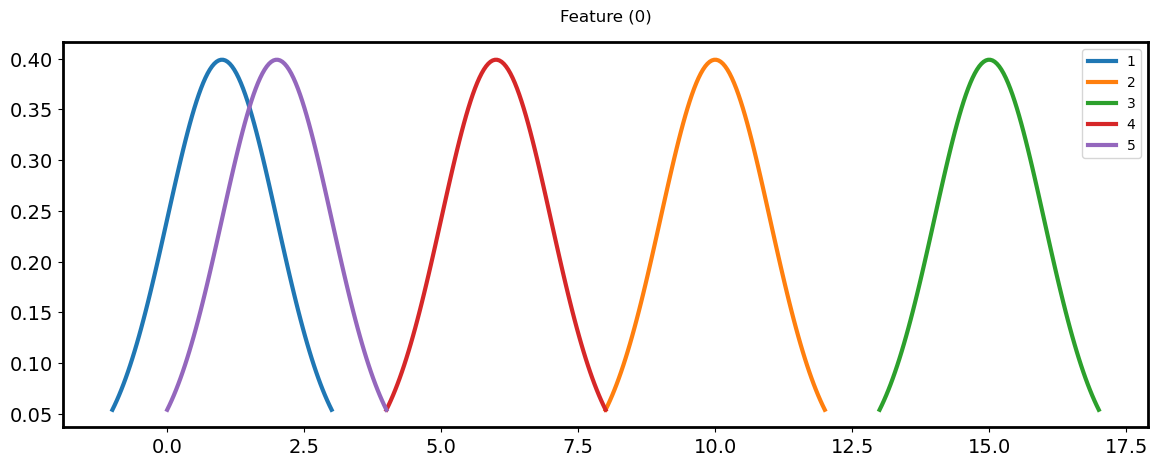

In [4]:
Gauss1 = Densities.Gaussian()
mu = np.array([ [1.0] , [10.], [15.], [6.], [2.] ])
var = 1.*np.ones(mu.shape)
X1 =np.array( [ 1.,1.,8.,10.,12.,4.,4.5,3.,4.5,4.5,3.,0. ] ).reshape(-1,1)
X2 = X1 + np.random.normal(scale=1., size=X1.shape)
Gauss1.init_model(mu=mu,var=var,classes=[1,2,3,4,5])
Gauss1.print_model()
Gauss1.plot_model()

In [5]:
Gauss1.__dict__

{'priors': None,
 'var_smoothing': 1e-09,
 'n_classes': 5,
 'n_features_in_': 1,
 'theta_': array([[ 1.],
        [10.],
        [15.],
        [ 6.],
        [ 2.]]),
 'var_': array([[1.],
        [1.],
        [1.],
        [1.],
        [1.]]),
 'classes_': array([1, 2, 3, 4, 5]),
 'class_prior_': array([0.2, 0.2, 0.2, 0.2, 0.2])}

### HMM with a Gaussian Observation Model

The frame classifiers above did not make use of the inherent sequence property of our data. We will now exploit the fact that we expect the data to be drawn in sequence from states 0-1-2.  Though we will not enforce this 100% as occasionally there are random switches between states.   

We make two hmm-models with the same init and transition probabilities.  
The model has a tendency left-to-right, though a very small probability allows for breaking this topology
- hmm1 : uses Gauss1 (intuitive) as observation model
- hmm2 : uses Gauss2 (trained) as observation model

We use log-prob's throughout to accomodate for small probs and long sequences

In [6]:
hmm1 = libhmm.HMM(prob_style="log",obs_model=Gauss1,n_states=5,prob_floor=1.e-20)
hmm1.init_topology(type="lr",selfprob=.8)
hmm1.print_model()


HMM STATE MODEL



,1,2,3,4,5
Pinit(.),0.000,-46.052,-46.052,-46.052,-46.052


,1,2,3,4,5
P(1|.),-0.223,-46.052,-46.052,-46.052,-46.052
P(2|.),-1.609,-0.223,-46.052,-46.052,-46.052
P(3|.),-46.052,-1.609,-0.223,-46.052,-46.052
P(4|.),-46.052,-46.052,-1.609,-0.223,-46.052
P(5|.),-46.052,-46.052,-46.052,-1.609,0.000



OBSERVATION MODEL

Means
[[ 1.]
 [10.]
 [15.]
 [ 6.]
 [ 2.]]
Variance
[[1.]
 [1.]
 [1.]
 [1.]
 [1.]]


## Trellis Computatitons

In the next cell
- Select model  hmm1 or hmm2
- Select Datastream and reference alignment  (X1,X2,X3,X4 or X2s,X3s,X4s)
- Compute the Viterbi Trellis (Normalize=True: max value =1.0 for prob or 0.0 for logprob)

In [7]:
X = X2
hmm = hmm1
tr = libhmm.Trellis(hmm)
tr.viterbi_pass(X)
tr.print_trellis(what=['obs_probs','probs'])


Observation Probabilities



,0,1,2,3,4,5,6,7,8,9,10,11
1,-0.967,-0.925,-27.393,-34.012,-71.465,-5.474,-3.750,-8.844,-4.189,-12.124,-2.056,-1.768
2,-44.261,-40.399,-2.404,-1.293,-5.061,-18.809,-22.835,-13.513,-21.674,-10.019,-28.982,-53.998
3,-103.313,-97.329,-23.522,-18.115,-3.170,-61.218,-68.438,-51.107,-66.388,-43.849,-78.941,-118.014
4,-15.019,-12.855,-3.510,-5.835,-24.574,-2.882,-4.353,-1.438,-3.903,-0.954,-7.015,-20.785
5,-1.778,-1.311,-20.616,-26.377,-60.087,-2.956,-1.870,-5.363,-2.131,-7.890,-1.048,-3.571



Trellis Probabilities (Viterbi)



,0,1,2,3,4,5,6,7,8,9,10,11
1,-0.967,-2.116,-29.731,-63.967,-125.162,-63.950,-66.718,-75.292,-73.393,-85.070,-76.564,-78.556
2,-90.313,-42.975,-6.129,-7.645,-12.929,-31.962,-55.020,-68.756,-90.653,-82.964,-103.490,-131.163
3,-149.365,-144.347,-68.107,-25.854,-12.424,-73.865,-102.009,-107.736,-135.593,-116.795,-153.449,-195.180
4,-61.071,-59.874,-51.678,-57.735,-52.037,-16.916,-21.492,-23.153,-27.279,-28.456,-35.695,-56.702
5,-47.829,-48.330,-68.783,-78.558,-113.784,-56.602,-20.396,-25.759,-26.894,-34.784,-31.114,-34.685


C:\Users\dirk\Anaconda3\envs\py37\lib\site-packages\matplotlib\text.py:1215: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


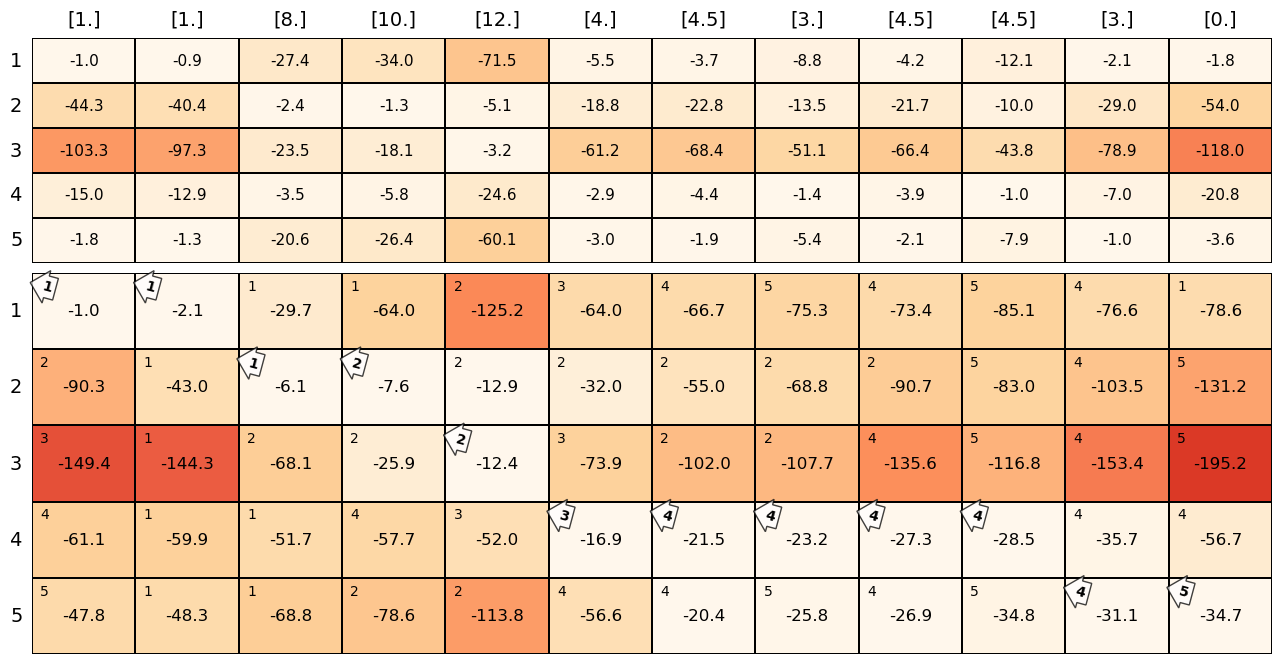

In [8]:
cmap="OrRd_r"
# column by column normalization is applied for the heatmap plotting of the trellis, 
tr.plot_trellis(xticks=X1,plot_norm=True,plot_obs_probs=True,plot_values=True,fmt=".1f",vmin=-220,vmax=0,
                 cmap=cmap,plot_backptrs=True,plot_alignment=True,figsize=(16,8))